In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, BatchNormalization, LeakyReLU, Dropout, Concatenate, ReLU
from tensorflow.keras.models import Model
import os
import numpy as np
from PIL import Image
import glob
import matplotlib.pyplot as plt
from tqdm import tqdm

# Paths to the folders containing the images
infrared_train_path = '/LLVIP/infrared/train/'
visible_train_path = '/LLVIP/visible/train/'
infrared_test_path = '/LLVIP/infrared/test/'
visible_test_path = '/LLVIP/visible/test/'

# Function to load and preprocess images
def load_image(image_path):
    image = Image.open(image_path)
    image = image.resize((256, 256))  # Resize to 256x256
    image = np.array(image).astype(np.float32)  # Cast to float32
    image = (image / 127.5) - 1  # Normalize to [-1, 1]
    return image

# Function to pair images
def load_image_pair(infrared_path, visible_path):
    infrared_image = load_image(infrared_path)
    visible_image = load_image(visible_path)
    return infrared_image, visible_image

2024-09-03 15:22:11.854946: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-03 15:22:11.865385: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-03 15:22:11.877462: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-03 15:22:11.881135: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-03 15:22:11.890858: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Get all paired file names
train_files = sorted(os.listdir(infrared_train_path))
test_files = sorted(os.listdir(infrared_test_path))

# Load and preprocess training images
train_input_images = []
train_target_images = []

In [3]:
import numpy as np
import os
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

def process_file(file_name):
    infrared_image_path = os.path.join(infrared_train_path, file_name)
    visible_image_path = os.path.join(visible_train_path, file_name)
    return load_image_pair(infrared_image_path, visible_image_path)

# Assuming all images are of the same shape
sample_image = load_image_pair(os.path.join(infrared_train_path, train_files[0]), 
                               os.path.join(visible_train_path, train_files[0]))[0]
image_shape = sample_image.shape
num_files = len(train_files)

# Preallocate NumPy arrays
train_input_images = np.empty((num_files, *image_shape), dtype=sample_image.dtype)
train_target_images = np.empty((num_files, *image_shape), dtype=sample_image.dtype)

with ThreadPoolExecutor() as executor:
    results = list(tqdm(executor.map(process_file, train_files), total=num_files))

for i, (input_img, target_img) in enumerate(results):
    train_input_images[i] = input_img
    train_target_images[i] = target_img

print(1)
print(2)


100%|██████████| 12025/12025 [00:48<00:00, 246.46it/s]


1
2


In [4]:
import numpy as np
import os
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

def process_test_file(file_name):
    infrared_image_path = os.path.join(infrared_test_path, file_name)
    visible_image_path = os.path.join(visible_test_path, file_name)
    return load_image_pair(infrared_image_path, visible_image_path)

# Preallocate lists for the validation images
val_input_images = []
val_target_images = []

# Use ThreadPoolExecutor to parallelize the loading process
with ThreadPoolExecutor() as executor:
    results = list(tqdm(executor.map(process_test_file, test_files), total=len(test_files)))

# Gather the results into the lists
for input_img, target_img in results:
    val_input_images.append(input_img)
    val_target_images.append(target_img)

# Convert lists to NumPy arrays
val_input_images = np.array(val_input_images)
val_target_images = np.array(val_target_images)

print(1)

# Ensure the input shapes are correct
print(train_input_images.shape)
print(train_target_images.shape)


100%|██████████| 3463/3463 [00:18<00:00, 190.67it/s]


1
(12025, 256, 256, 3)
(12025, 256, 256, 3)


In [5]:
BATCH_SIZE = 1
# Create TensorFlow Dataset objects
train_dataset = tf.data.Dataset.from_tensor_slices((train_input_images, train_target_images))
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices((val_input_images, val_target_images))
val_dataset = val_dataset.batch(BATCH_SIZE)

# The rest of the code remains unchanged and should work seamlessly with this new dataset.

2024-09-03 15:24:33.283375: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78404 MB memory:  -> device: 0, name: NVIDIA H100 PCIe, pci bus id: 0000:81:00.0, compute capability: 9.0


In [6]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                      kernel_initializer=initializer, use_bias=False))
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
    result.add(tf.keras.layers.LeakyReLU())
    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                               kernel_initializer=initializer, use_bias=False))
    result.add(tf.keras.layers.BatchNormalization())
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    result.add(tf.keras.layers.ReLU())
    return result

def Generator():
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])
    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (bs, 128, 128, 64)
        downsample(128, 4),  # (bs, 64, 64, 128)
        downsample(256, 4),  # (bs, 32, 32, 256)
        downsample(512, 4),  # (bs, 16, 16, 512)
        downsample(512, 4),  # (bs, 8, 8, 512)
        downsample(512, 4),  # (bs, 4, 4, 512)
        downsample(512, 4),  # (bs, 2, 2, 512)
        downsample(512, 4),  # (bs, 1, 1, 512)
    ]
    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True),  # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True),  # (bs, 8, 8, 1024)
        upsample(512, 4),  # (bs, 16, 16, 1024)
        upsample(256, 4),  # (bs, 32, 32, 512)
        upsample(128, 4),  # (bs, 64, 64, 256)
        upsample(64, 4),  # (bs, 128, 128, 128)
    ]
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(3, 4,
                                           strides=2,
                                           padding='same',
                                           kernel_initializer=initializer,
                                           activation='tanh')  # (bs, 256, 256, 3)
    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])
    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)


In [7]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')
    x = tf.keras.layers.concatenate([inp, tar])
    down1 = downsample(64, 4, False)(x)
    down2 = downsample(128, 4)(down1)
    down3 = downsample(256, 4)(down2)
    down4 = downsample(512, 4)(down3)
    last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer, padding='same')(down4)
    return tf.keras.Model(inputs=[inp, tar], outputs=last)


In [8]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss

def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = gan_loss + (100 * l1_loss)
    return total_gen_loss


In [9]:
class Pix2Pix(tf.keras.Model):
    def __init__(self, generator, discriminator, generator_optimizer, discriminator_optimizer, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.generator = generator
        self.discriminator = discriminator
        self.generator_optimizer = generator_optimizer
        self.discriminator_optimizer = discriminator_optimizer

    def compile(self, generator_loss, discriminator_loss, *args, **kwargs):
        super().compile(*args, **kwargs)
        self.generator_loss = generator_loss
        self.discriminator_loss = discriminator_loss

    def train_step(self, data):
        input_image, target = data
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            gen_output = self.generator(input_image, training=True)
            disc_real_output = self.discriminator([input_image, target], training=True)
            disc_generated_output = self.discriminator([input_image, gen_output], training=True)
            gen_loss = self.generator_loss(disc_generated_output, gen_output, target)
            disc_loss = self.discriminator_loss(disc_real_output, disc_generated_output)
        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)
        self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        self.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))
        return {"gen_loss": gen_loss, "disc_loss": disc_loss}
    
    def call(self, inputs):
        return self.generator(inputs)


In [10]:
# Instantiate the generator and discriminator
generator = Generator()
discriminator = Discriminator()

# Instantiate the optimizers
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Instantiate the custom model
pix2pix_model = Pix2Pix(generator, discriminator, generator_optimizer, discriminator_optimizer)

# Compile the model
pix2pix_model.compile(
    generator_loss=generator_loss,
    discriminator_loss=discriminator_loss,
    loss='binary_crossentropy'  # Dummy loss
)

In [27]:
# Function to reverse the input-target pairs in the dataset
def reverse_dataset(dataset):
    return dataset.map(lambda input_img, target_img: (target_img, input_img))

# Reverse the training and validation datasets
reversed_train_dataset = reverse_dataset(train_dataset)
reversed_val_dataset = reverse_dataset(val_dataset)

# Fit the model using the reversed datasets
EPOCHS = 100
pix2pix_model.fit(reversed_train_dataset, epochs=EPOCHS, validation_data=reversed_val_dataset)

Epoch 1/100
12025/12025 ━━━━━━━━━━━━━━━━━━━━ 143s 11ms/step - disc_loss: 0.6530 - gen_loss: 11.4415 - val_loss: -5.1702
Epoch 2/100
12025/12025 ━━━━━━━━━━━━━━━━━━━━ 138s 11ms/step - disc_loss: 0.6452 - gen_loss: 10.7310 - val_loss: -5.1341
Epoch 3/100
12025/12025 ━━━━━━━━━━━━━━━━━━━━ 137s 11ms/step - disc_loss: 0.6420 - gen_loss: 10.2977 - val_loss: -5.0918
Epoch 4/100
10851/12025 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - disc_loss: 0.6545 - gen_loss: 9.9318

KeyboardInterrupt: 

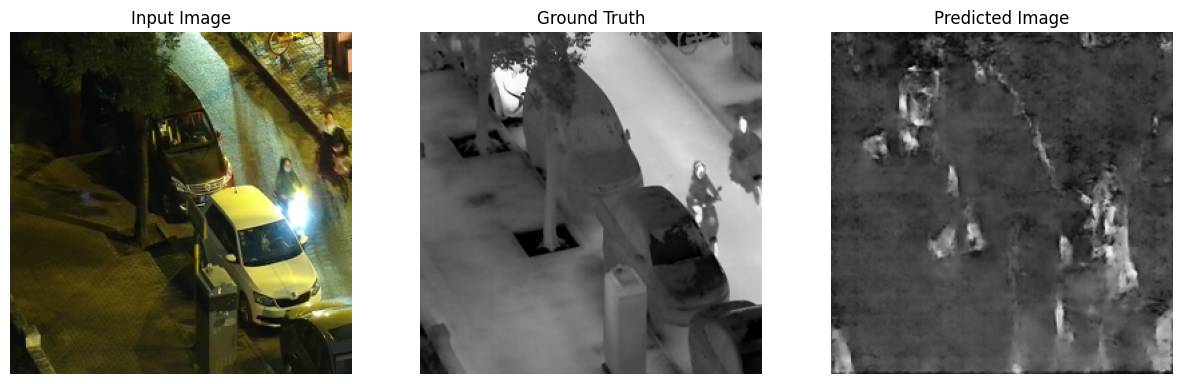

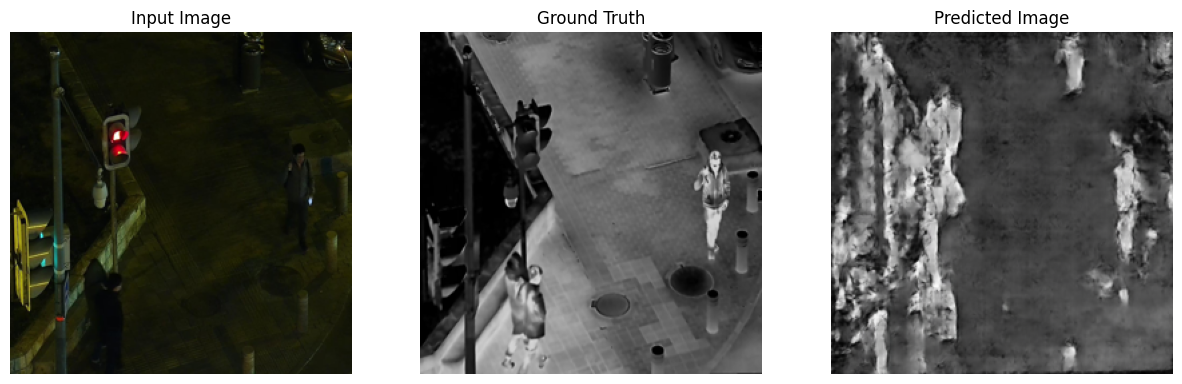

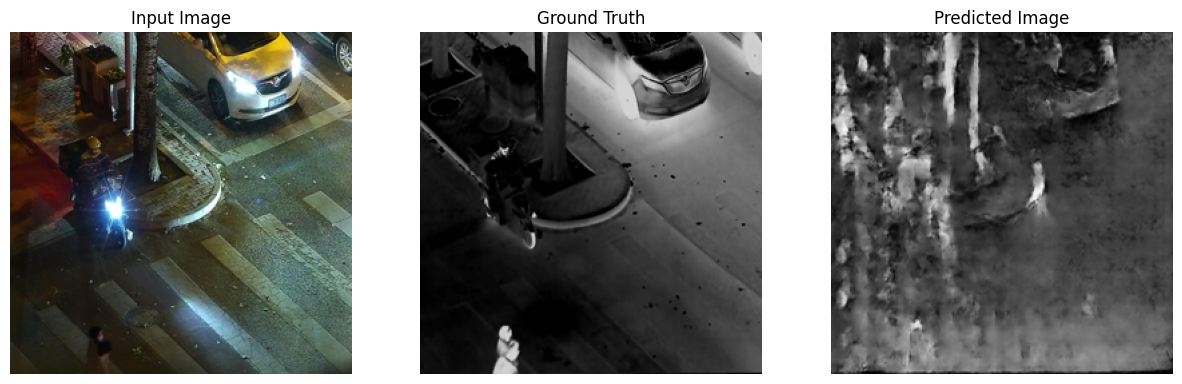

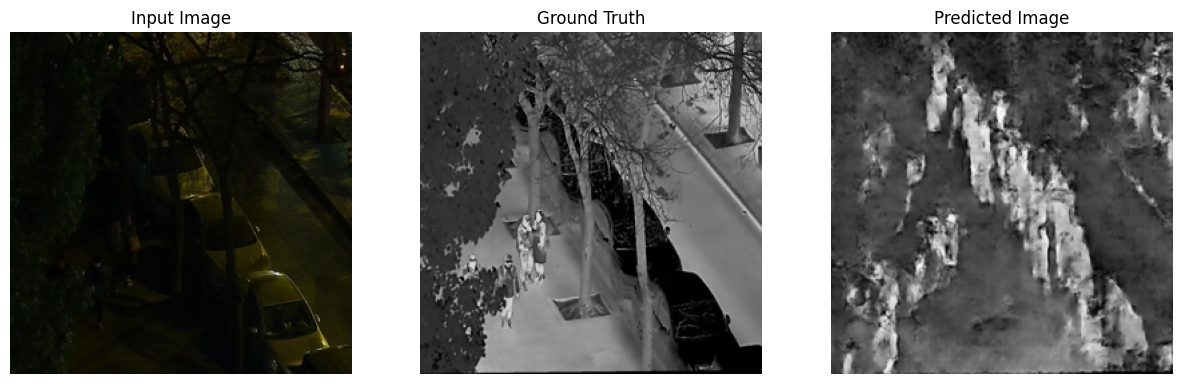

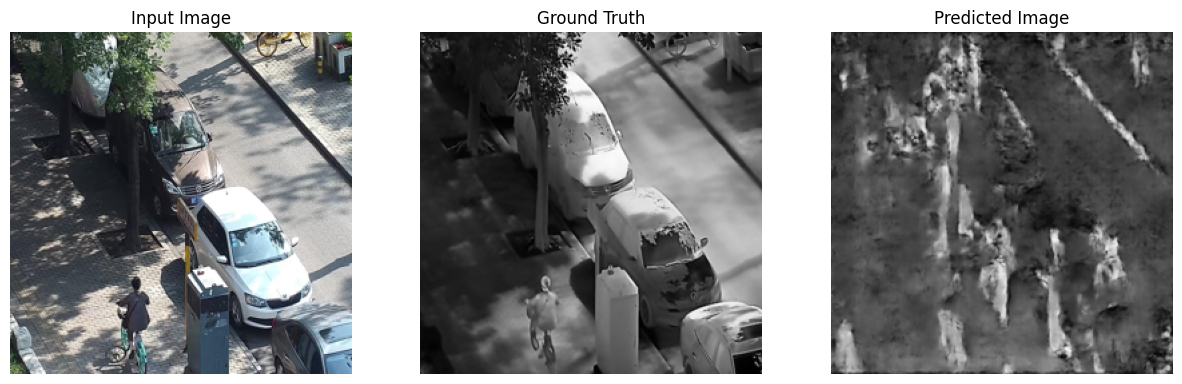

In [28]:
import matplotlib.pyplot as plt
import random

def generate_and_display_images(model, test_input, target):
    prediction = model(test_input, training=False)

    plt.figure(figsize=(15, 15))

    # Swapping the first and second images in display_list
    display_list = [target[0], test_input[0], prediction[0]]  
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # Getting the pixel values back to [0, 1]
        plt.imshow((display_list[i] + 1) / 2.0)
        plt.axis('off')
    plt.show()

# Get the total number of elements in the dataset
val_dataset_size = sum(1 for _ in val_dataset)

# Randomly select 5 unique indices from the dataset
random_indices = sorted(random.sample(range(val_dataset_size), 5))  # Sort indices to keep order

# Collect the selected images
selected_images = []
for i, (example_input, example_target) in enumerate(val_dataset):
    if i in random_indices:
        selected_images.append((example_input, example_target))

# Display the selected images in the correct order
for example_input, example_target in selected_images:
    generate_and_display_images(pix2pix_model.generator, example_input, example_target)